In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr
from scipy.interpolate import interp1d

In [2]:
class DataCleaner:
    
    def __init__(self, ds):
        
        self.ds = ds
        
    def clean_entire_nan_columns_non_zero_thick(self, var, thick_var, replace_with = 0.0):
    
        # For interpolated variables, thick_var has to be some interpolated thickness, otherwise shapes won't match
        
        variable = self.ds.variables[var]
        thick = self.ds.variables[thick_var]
        
        shape_z, shape_x, shape_y = variable.shape

        sum_nan_columns = np.sum(np.isnan(variable), axis = 0)
        
        for i in range(shape_x):
            for j in range(shape_y):
                if sum_nan_columns[i,j] == shape_z and thick[i,j] == 0.0:
                    variable[:,i,j] = replace_with
                    
        self.ds.variables[var][:] = variable
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', Clear all NaN columns'
        else:
            
            self.ds[var].attrs['modifications'] = 'Clear all NaN columns'
                   
    def nan_stats(self, var, thick_var):
        
        # For interpolated variables, thick_var has to be some interpolated thickness, otherwise shapes won't match
        
        variable = self.ds.variables[var]
        shape_z, shape_x, shape_y = variable.shape
        num_nan_columns = 0
        flag_nan_columns = np.zeros((shape_x, shape_y), dtype = int)
        
        sum_nan_columns = np.sum(np.isnan(variable), axis = 0)
        flag_nan_columns = sum_nan_columns == shape_z
        num_nan_columns = np.sum(flag_nan_columns)
        
        flag_non_zero_thick = self.ds.variables[thick_var] > 0.0

        flag_nan_columns_nonzero_thick = np.logical_and(flag_non_zero_thick, flag_nan_columns)
        num_nan_columns_nonzero_thick = np.sum(flag_nan_columns_nonzero_thick)
        
        num_nan_z_levels = np.sum(np.isnan(variable), axis = (1,2))
        
        flag_nan = np.isnan(variable)
        
        ### Pad a with 0 at both sides for edge cases when a starts or ends with 1
        ### See answer by Psidom - 
        ### https://stackoverflow.com/questions/54446907/how-to-calculate-numbers-of-uninterrupted-repeats-in-an-array-in-python/54447096#54447096

        ### In our case, pad only in the z-dimension
        temp = np.pad(flag_nan, pad_width=((1, 1), (0, 0), (0, 0)), mode='constant')
        flag_num_nan_patches_columns = np.sum(np.logical_xor(temp[1:], temp[:-1]) == True, axis = 0) / 2
        flag_num_nan_patches_columns = flag_num_nan_patches_columns.astype(int)
        statsDict = {}
        flagsDict = {}
        
        statsDict['Total NaNs'] = np.count_nonzero(np.isnan(variable))
        statsDict['Total NaN columns'] = num_nan_columns
        statsDict['Total NaN columns with non-zero ice thickness'] = num_nan_columns_nonzero_thick
        statsDict['Total NaN on different z-levels'] = num_nan_z_levels
        
        flagsDict['Flag for all NaN columns'] = flag_nan_columns
        flagsDict['Total NaN in each column'] = sum_nan_columns
        flagsDict['Flag for all NaN columns, non-zero thick'] = flag_nan_columns_nonzero_thick
        flagsDict['Flag for num of contiguous NaN patches in cols'] = flag_num_nan_patches_columns
        
        return statsDict, flagsDict
    
    def clean_middle_nans(self, var, kind = 'linear'):
        
        def middle_clean_column(z, 
                                #z_interp,
                                var_column, kind = 'linear'):

            start = np.where(~np.isnan(var_column))[0][0]
            end = np.where(~np.isnan(var_column))[0][-1]

            z_middle = z[start:end+1]

            var_column_copy = np.copy(var_column)

            var_column_middle = var_column_copy[start:end+1]

            #z_interp_middle = z_interp[z_interp >= z_middle[0]]
            #z_interp_middle = z_interp_middle[z_interp_middle <= z_middle[-1]]

            flag_not_nan_middle = ~np.isnan(var_column_middle)

            f = interp1d(z_middle[flag_not_nan_middle], var_column_middle[flag_not_nan_middle], kind = kind)

            var_column_copy[start:end+1] = f(z_middle) # f(z_interp_middle)

            return var_column_copy
        
        variable_values = self.ds.variables[var].values
        
        shape_z, shape_x, shape_y = variable_values.shape
        
        var_middle_clean = var + '_middle_clean'
        
        for i in range(shape_x):
            for j in range(shape_y):
                
                if np.sum(np.isnan(variable_values[:,i,j])) in [0, shape_z - 1, shape_z]:
                    pass
                else:
                    variable_values[:,i,j] = middle_clean_column(np.arange(shape_z), variable_values[:,i,j])
    
        self.ds.variables[var][:] = variable_values
    
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                f', Clean middle columns using {kind} interpolation'
        else:
            
            self.ds[var].attrs['modifications'] = f'Clean middle columns using {kind} interpolation'
        

In [3]:
class DataInterpolator(DataCleaner):
    
    def __init__(self, ds, 
                 model_x, model_y, model_KCMAX, model_exp_a = 2.0,
                 method = 'nearest_neighbor'):
        
        super().__init__(ds)
        
        self.ds = ds
        
        self.model_x = model_x
        self.model_y = model_y
        self.model_KCMAX = model_KCMAX
        self.model_exp_a = model_exp_a
        self.method = method
        
        if self.method != 'nearest_neighbor':
            raise NotImplementedError("Only nearest_neighbor interpolation is available.")

    def expand_dims(self):
        
        self.ds_expanded = xr.Dataset()
        
        Dict = {}
        Dict['number of model grid points in x-direction'] = self.model_x.shape[0]
        Dict['number of model grid points in y-direction'] = self.model_y.shape[0]
        Dict['number of vertical model layers'] = self.model_KCMAX + 1
        
        self.ds_expanded = self.ds_expanded.expand_dims(Dict)

    def add_model_variables(self):
        
        x_model_mesh, y_model_mesh = np.meshgrid(self.model_x, self.model_y)
        
        self.ds_expanded['x_model'] = (['number of model grid points in x-direction', 
                               'number of model grid points in y-direction'], x_model_mesh.T)
        self.ds_expanded['y_model'] = (['number of model grid points in x-direction', 
                               'number of model grid points in y-direction'], y_model_mesh.T)
        self.ds_expanded['zeta_c_model'] = (['number of vertical model layers'], np.linspace(0.,1.,self.model_KCMAX+1))
        
        zeta_c_model_exp = (np.exp(self.model_exp_a*self.ds_expanded['zeta_c_model'])-1) \
                          /(np.exp(self.model_exp_a)-1)
        
        self.ds_expanded['zeta_c_exp_model'] = (['number of vertical model layers'], zeta_c_model_exp.values)
        self.ds_expanded['zeta_c_exp_model'].attrs['Exp parameter'] = self.model_exp_a
        
    def unfreeze_ds(self):
        ### ds.dim will show that the dataset is frozen and we cannot add more dimensions
        ### Instead we will create a new dataset
        
        ds_unfrozen = self.ds_expanded.copy()
        
        ds_unfrozen.attrs = self.ds.attrs

        for key, value in self.ds.variables.items():
            ds_unfrozen[key] = value

        self.ds = ds_unfrozen.copy() 
        
    def add_top_layer(self, var):
        
        ### This operation only makes sense for original variables
        ### You should add top layer and then interpolate in the vertical
        
        variable = self.ds.variables[var]
        
        shape_z, shape_x, shape_y = variable.shape
        
        var_new = var + '_TopLayerAdded'
        
        variable_new = np.zeros((shape_z+1, shape_x, shape_y), dtype = float)
        variable_new[1:] = np.copy(variable.values)
        
        self.ds[var_new] = (['number of vertical layers with top layer added', 
                                'number of grid points in x-direction', 
                                'number of grid points in y-direction'], 
                               variable_new)      

        self.ds[var_new].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_new].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', Top layer added'
        else:
            
            self.ds[var_new].attrs['modifications'] = 'Top layer added'
            
    def reverse_vertically(self, var):
        
        ### Only do this after adding top layer
        
        variable = self.ds.variables[var]
        
        shape_z, shape_x, shape_y = variable.shape
        
        var_new = var + '_Reversed'
        
        variable_new = np.zeros((shape_z, shape_x, shape_y), dtype = float)
        variable_new = np.copy(variable.values[::-1])
        
        self.ds[var_new] = (['number of vertical layers with top layer added', 
                                'number of grid points in x-direction', 
                                'number of grid points in y-direction'], 
                               variable_new)      

        self.ds[var_new].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_new].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', Reversed vertically'
        else:
            
            self.ds[var_new].attrs['modifications'] = 'Reversed vertically'
            
    def NN_2D(self):
        
        self.data_x_closest_indices = np.zeros(self.model_x.shape, dtype = int)
        self.data_y_closest_indices = np.zeros(self.model_y.shape, dtype = int)
    
        for i in range(self.model_x.shape[0]):
            
            self.data_x_closest_indices[i] = np.abs(self.model_x[i] - self.ds['x'][:,0]).argmin()
        
        for j in range(self.model_y.shape[0]):

            self.data_y_closest_indices[j] = np.abs(self.model_y[j] - self.ds['y'][0,:]).argmin()

        self.ds['thick_2D_interp'] = (['number of model grid points in x-direction', 
                                       'number of model grid points in y-direction'], 
                                      self.ds.variables['thick'].values[np.ix_(self.data_x_closest_indices, self.data_y_closest_indices)])

        self.ds['thick_2D_interp'].attrs['Base variable'] = 'thick'

        if 'modifications' in self.ds['thick'].attrs:
            
            self.ds['thick_2D_interp'].attrs['modifications'] = self.ds['thick'].attrs['modifications'] + \
                                                                ', 2D Nearest Neighbor Interpolation'
        else:
            
            self.ds['thick_2D_interp'].attrs['modifications'] = '2D Nearest Neighbor Interpolation'
        
    def NN_2D_var(self, var):
        
        variable = self.ds.variables[var]
        
        shape_z, shape_x, shape_y = variable.shape
        
        var_interp = var + '_2D_interp'
        
        variable_interp = variable.values[np.ix_(range(shape_z), self.data_x_closest_indices, self.data_y_closest_indices)] 
        
        self.ds[var_interp] = (['number of vertical layers with top layer added', 
                                'number of model grid points in x-direction', 
                                'number of model grid points in y-direction'], 
                               variable_interp)
        
        self.ds[var_interp].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_interp].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', 2D Nearest Neighbor Interpolation'
        else:
            
            self.ds[var_interp].attrs['modifications'] = '2D Nearest Neighbor Interpolation'
            
    def z_interpolation_middle_columns(self, var, kind = 'linear'):
        
        ### Assumed that the middle of the columns have no NaNs

        def interp_one_column_middle(z, z_interp, var_column, kind = 'linear'):

            var_column_interp = np.empty(len(z_interp))
            var_column_interp[:] = np.NaN
            
            start = np.where(~np.isnan(var_column))[0][0]
            end = np.where(~np.isnan(var_column))[0][-1]

            z_middle = z[start:end+1]

            var_column_middle = var_column[start:end+1]

            z_interp_middle = z_interp[z_interp >= z_middle[0]]
            start_interp = len(z_interp) - len(z_interp_middle)
            z_interp_middle = z_interp_middle[z_interp_middle <= z_middle[-1]]
            end_interp = len(z_interp_middle) + start_interp - 1

            f = interp1d(z_middle, var_column_middle, kind = kind)

            var_column_interp[start_interp:end_interp+1] = f(z_interp_middle)

            return var_column_interp
        
        variable_values = self.ds.variables[var].values
        
        shape_z, shape_x, shape_y = variable_values.shape
        
        var_interp = var + f'_z_interp_{kind}'
        
        variable_interp_values = np.empty((self.model_KCMAX + 1, shape_x, shape_y), dtype = float)
        variable_interp_values[:] = np.NaN
        
        zeta_c_data = np.linspace(0., 1., len(self.ds['number of vertical layers with top layer added']))
        zeta_c_model = self.ds['zeta_c_exp_model'].values
        
        for i in range(shape_x):
            for j in range(shape_y):
                
                if np.sum(np.isnan(variable_values[:,i,j])) in [shape_z - 1, shape_z]:
                    pass
                else:
                    variable_interp_values[:,i,j] = interp_one_column_middle(zeta_c_data,
                                                                            zeta_c_model, 
                                                                            variable_values[:,i,j], 
                                                                            kind = kind)
        
        self.ds[var_interp] = (['number of vertical model layers', 
                                'number of model grid points in x-direction', 
                                'number of model grid points in y-direction'], 
                                variable_interp_values)
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_interp].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                f', z {kind} interpolation'
        else:
            
            self.ds[var_interp].attrs['modifications'] = f'z {kind} interpolation'

In [4]:
### Reading a netcdf file
ds = xr.open_dataset('RRRAG4_Greenland_1993_2013_01_age_grid.nc')

In [5]:
ds

<xarray.Dataset>
Dimensions:           (number of isochrones: 4, number of grid points in x-direction: 1479, number of grid points in y-direction: 2675, number of vertical layers: 25)
Dimensions without coordinates: number of isochrones, number of grid points in x-direction, number of grid points in y-direction, number of vertical layers
Data variables:
    depth_iso         (number of isochrones, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    depth_iso_uncert  (number of isochrones, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    age_norm          (number of vertical layers, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    age_norm_uncert   (number of vertical layers, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    x                 (number of grid points in x-direction, number of grid points in y-direction) float64 ...
    y                 (number of grid points in x-direction, number of grid points in y-direction) float64 ...
    age_iso           (number of isochrones) float64 ...
    num_age_iso       float64 ...
    depth_norm        (number of vertical layers) float64 ...
    num_depth_norm    float64 ...
    thick             (number of grid points in x-direction, number of grid points in y-direction) float64 ...
Attributes:
    title:               Gridded age structure of the Greenland Ice Sheet
    original file name:  Greenland_age_grid.nc
    version:             1.2
    citation:            MacGregor, J.A., M.A. Fahnestock, G.A. Catania, J.D....
    date generated:      01-Apr-2015 08:59:30
    point of contact:    Joseph MacGregor, joemac@ig.utexas.edu
    grid projection:     EPSG:3413

In [6]:
x_model_10km = np.arange(-72.,97.,1.)*10
y_model_10km = np.arange(-345.,-56.,1.)*10
KCMAX = 80

In [7]:
DI = DataInterpolator(ds, x_model_10km, y_model_10km, KCMAX)
DI.expand_dims()
DI.add_model_variables()
DI.unfreeze_ds()
DI.add_top_layer('age_norm')
DI.reverse_vertically('age_norm_TopLayerAdded')
DI.NN_2D()
DI.NN_2D_var('age_norm_TopLayerAdded_Reversed')
DI.clean_middle_nans('age_norm_TopLayerAdded_Reversed_2D_interp', kind = 'linear')
DI.z_interpolation_middle_columns('age_norm_TopLayerAdded_Reversed_2D_interp', kind = 'linear')

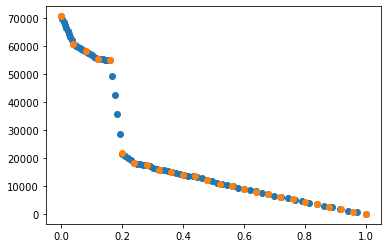

In [8]:
plt.scatter(DI.ds['zeta_c_exp_model'], DI.ds['age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear'][:,100,180])
plt.scatter(np.linspace(0., 1., len(DI.ds['number of vertical layers with top layer added'])),DI.ds['age_norm_TopLayerAdded_Reversed_2D_interp'][:,100,180])

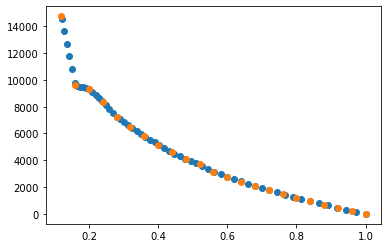

In [9]:
plt.scatter(DI.ds['zeta_c_exp_model'], DI.ds['age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear'][:,75,100])
plt.scatter(np.linspace(0., 1., len(DI.ds['number of vertical layers with top layer added'])),DI.ds['age_norm_TopLayerAdded_Reversed_2D_interp'][:,75,100])

In [10]:
stats, flags = DI.nan_stats('age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear', 'thick_2D_interp')

In [11]:
stats

{'Total NaNs': 3178038,
 'Total NaN columns': <xarray.Variable ()>
 array(36192),
 'Total NaN columns with non-zero ice thickness': <xarray.Variable ()>
 array(5401),
 'Total NaN on different z-levels': <xarray.Variable (number of vertical model layers: 81)>
 array([47312, 47312, 47312, 47312, 47312, 47312, 47312, 47312, 47312,
        47312, 44948, 44948, 44948, 44948, 44948, 44948, 44948, 42606,
        42606, 42606, 42606, 42606, 42606, 39520, 39520, 39520, 39520,
        39520, 39520, 37761, 37761, 37761, 37761, 36957, 36957, 36957,
        36957, 36957, 36651, 36651, 36651, 36651, 36492, 36492, 36492,
        36403, 36403, 36403, 36377, 36377, 36377, 36337, 36337, 36337,
        36315, 36315, 36315, 36308, 36308, 36282, 36282, 36250, 36250,
        36250, 36219, 36219, 36213, 36213, 36211, 36194, 36194, 36194,
        36194, 36194, 36194, 36192, 36192, 36192, 36192, 36192, 36192])}

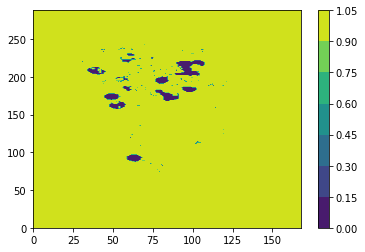

In [12]:
plt.contourf(flags['Flag for num of contiguous NaN patches in cols'].T)
plt.colorbar()

In [13]:
DI.ds

<xarray.Dataset>
Dimensions:                                                    (number of model grid points in x-direction: 169, number of model grid points in y-direction: 289, number of vertical model layers: 81, number of isochrones: 4, number of grid points in x-direction: 1479, number of grid points in y-direction: 2675, number of vertical layers: 25, number of vertical layers with top layer added: 26)
Dimensions without coordinates: number of model grid points in x-direction, number of model grid points in y-direction, number of vertical model layers, number of isochrones, number of grid points in x-direction, number of grid points in y-direction, number of vertical layers, number of vertical layers with top layer added
Data variables: (12/20)
    x_model                                                    (number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
    y_model                                                    (number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
    zeta_c_model                                               (number of vertical model layers) float64 ...
    zeta_c_exp_model                                           (number of vertical model layers) float64 ...
    depth_iso                                                  (number of isochrones, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    depth_iso_uncert                                           (number of isochrones, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    ...                                                         ...
    thick                                                      (number of grid points in x-direction, number of grid points in y-direction) float64 ...
    age_norm_TopLayerAdded                                     (number of vertical layers with top layer added, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    age_norm_TopLayerAdded_Reversed                            (number of vertical layers with top layer added, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    thick_2D_interp                                            (number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
    age_norm_TopLayerAdded_Reversed_2D_interp                  (number of vertical layers with top layer added, number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
    age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear  (number of vertical model layers, number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
Attributes:
    title:               Gridded age structure of the Greenland Ice Sheet
    original file name:  Greenland_age_grid.nc
    version:             1.2
    citation:            MacGregor, J.A., M.A. Fahnestock, G.A. Catania, J.D....
    date generated:      01-Apr-2015 08:59:30
    point of contact:    Joseph MacGregor, joemac@ig.utexas.edu
    grid projection:     EPSG:3413

In [14]:
DI.ds['age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear'].shape

(81, 169, 289)